## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [12]:
import os
import keras
import itertools

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [13]:
train, test = keras.datasets.cifar10.load_data()

In [14]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [15]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [16]:
#建立神經網路，並加入 L1 或 L2
from keras.regularizers import l1, l2, l1_l2
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [17]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [18]:
#使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
results = {}
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 5s 22ms/step - los

Epoch 1/10
196/196 [==============================] - 4s 20ms/step - loss: 300.5076 - accuracy: 0.1909 - val_loss: 41.0943 - val_accuracy: 0.2533
Epoch 2/10
196/196 [==============================] - 4s 20ms/step - loss: 27.3134 - accuracy: 0.1584 - val_loss: 7.2777 - val_accuracy: 0.1000
Epoch 3/10
196/196 [==============================] - 3s 17ms/step - loss: 5.2783 - accuracy: 0.1024 - val_loss: 2.6472 - val_accuracy: 0.1000
Epoch 4/10
196/196 [==============================] - 4s 18ms/step - loss: 2.5255 - accuracy: 0.0969 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 5/10
196/196 [==============================] - 4s 20ms/step - loss: 2.4626 - accuracy: 0.0992 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 6/10
196/196 [==============================] - 4s 18ms/step - loss: 2.4626 - accuracy: 0.0996 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 7/10
196/196 [==============================] - 4s 18ms/step - loss: 2.4626 - accuracy: 0.0953 - val_loss: 2.4626 - val_accuracy: 0.

Epoch 6/10
196/196 [==============================] - 4s 18ms/step - loss: 5.3663 - accuracy: 0.4442 - val_loss: 5.3115 - val_accuracy: 0.4386
Epoch 7/10
196/196 [==============================] - 3s 18ms/step - loss: 5.2681 - accuracy: 0.4562 - val_loss: 5.2238 - val_accuracy: 0.4471
Epoch 8/10
196/196 [==============================] - 3s 18ms/step - loss: 5.1653 - accuracy: 0.4678 - val_loss: 5.1304 - val_accuracy: 0.4510
Epoch 9/10
196/196 [==============================] - 4s 18ms/step - loss: 5.0737 - accuracy: 0.4767 - val_loss: 5.0303 - val_accuracy: 0.4675
Epoch 10/10
196/196 [==============================] - 3s 18ms/step - loss: 4.9821 - accuracy: 0.4851 - val_loss: 4.9563 - val_accuracy: 0.4754
Experiment with L1 = 0.000100, L2 = 0.000000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
__________________________

Epoch 1/10
196/196 [==============================] - 4s 19ms/step - loss: 15.6544 - accuracy: 0.2100 - val_loss: 13.9356 - val_accuracy: 0.3390
Epoch 2/10
196/196 [==============================] - 3s 18ms/step - loss: 13.4504 - accuracy: 0.3464 - val_loss: 12.1165 - val_accuracy: 0.3733
Epoch 3/10
196/196 [==============================] - 4s 18ms/step - loss: 11.7118 - accuracy: 0.3769 - val_loss: 10.5890 - val_accuracy: 0.3873
Epoch 4/10
196/196 [==============================] - 3s 18ms/step - loss: 10.2504 - accuracy: 0.3931 - val_loss: 9.2872 - val_accuracy: 0.3990
Epoch 5/10
196/196 [==============================] - 3s 18ms/step - loss: 8.9991 - accuracy: 0.4026 - val_loss: 8.1856 - val_accuracy: 0.4139
Epoch 6/10
196/196 [==============================] - 3s 18ms/step - loss: 7.9296 - accuracy: 0.4168 - val_loss: 7.2358 - val_accuracy: 0.4223
Epoch 7/10
196/196 [==============================] - 3s 18ms/step - loss: 7.0270 - accuracy: 0.4215 - val_loss: 6.4379 - val_accuracy:

Epoch 6/10
196/196 [==============================] - 3s 18ms/step - loss: 1.6036 - accuracy: 0.4407 - val_loss: 1.5899 - val_accuracy: 0.4379
Epoch 7/10
196/196 [==============================] - 3s 18ms/step - loss: 1.5655 - accuracy: 0.4525 - val_loss: 1.5553 - val_accuracy: 0.4496
Epoch 8/10
196/196 [==============================] - 3s 17ms/step - loss: 1.5301 - accuracy: 0.4642 - val_loss: 1.5303 - val_accuracy: 0.4602
Epoch 9/10
196/196 [==============================] - 3s 18ms/step - loss: 1.5012 - accuracy: 0.4718 - val_loss: 1.5169 - val_accuracy: 0.4567
Epoch 10/10
196/196 [==============================] - 3s 18ms/step - loss: 1.4773 - accuracy: 0.4805 - val_loss: 1.4874 - val_accuracy: 0.4753- loss: 1.4776 - accura
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
___

Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 4s 19ms/step - los

Epoch 1/10
196/196 [==============================] - 3s 15ms/step - loss: 15.6736 - accuracy: 0.2092 - val_loss: 13.9556 - val_accuracy: 0.3378
Epoch 2/10
196/196 [==============================] - 3s 14ms/step - loss: 13.4717 - accuracy: 0.3527 - val_loss: 12.1277 - val_accuracy: 0.3706
Epoch 3/10
196/196 [==============================] - 3s 14ms/step - loss: 11.7218 - accuracy: 0.3779 - val_loss: 10.5996 - val_accuracy: 0.3842
Epoch 4/10
196/196 [==============================] - 3s 14ms/step - loss: 10.2526 - accuracy: 0.3920 - val_loss: 9.3001 - val_accuracy: 0.4031
Epoch 5/10
196/196 [==============================] - 3s 14ms/step - loss: 9.0051 - accuracy: 0.4084 - val_loss: 8.1887 - val_accuracy: 0.4115
Epoch 6/10
196/196 [==============================] - 3s 14ms/step - loss: 7.9505 - accuracy: 0.4084 - val_loss: 7.2468 - val_accuracy: 0.4119
Epoch 7/10
196/196 [==============================] - 3s 14ms/step - loss: 7.0344 - accuracy: 0.4206 - val_loss: 6.4414 - val_accuracy:

Epoch 6/10
196/196 [==============================] - 3s 15ms/step - loss: 1.5872 - accuracy: 0.4413 - val_loss: 1.5696 - val_accuracy: 0.4488
Epoch 7/10
196/196 [==============================] - 3s 15ms/step - loss: 1.5519 - accuracy: 0.4552 - val_loss: 1.5440 - val_accuracy: 0.4554
Epoch 8/10
196/196 [==============================] - 3s 14ms/step - loss: 1.5171 - accuracy: 0.4678 - val_loss: 1.5253 - val_accuracy: 0.4617
Epoch 9/10
196/196 [==============================] - 3s 14ms/step - loss: 1.4981 - accuracy: 0.4750 - val_loss: 1.4998 - val_accuracy: 0.4703
Epoch 10/10
196/196 [==============================] - 3s 14ms/step - loss: 1.4610 - accuracy: 0.4875 - val_loss: 1.4911 - val_accuracy: 0.4654
Experiment with L1 = 0.000000, L2 = 0.000000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
__________________________

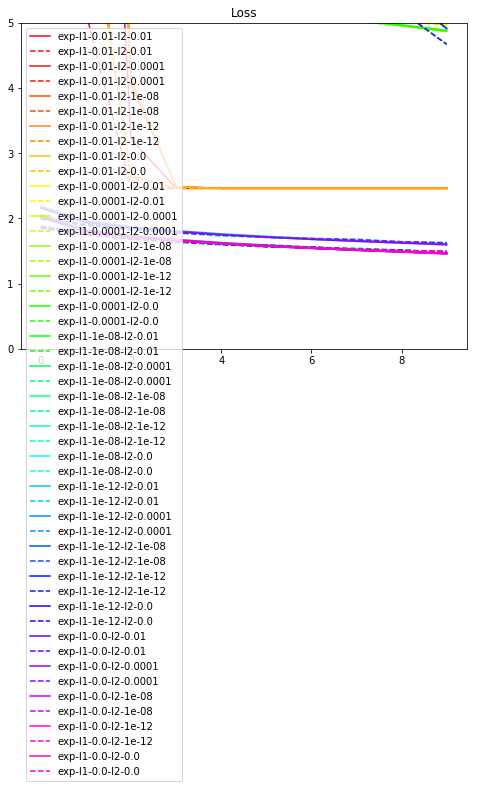

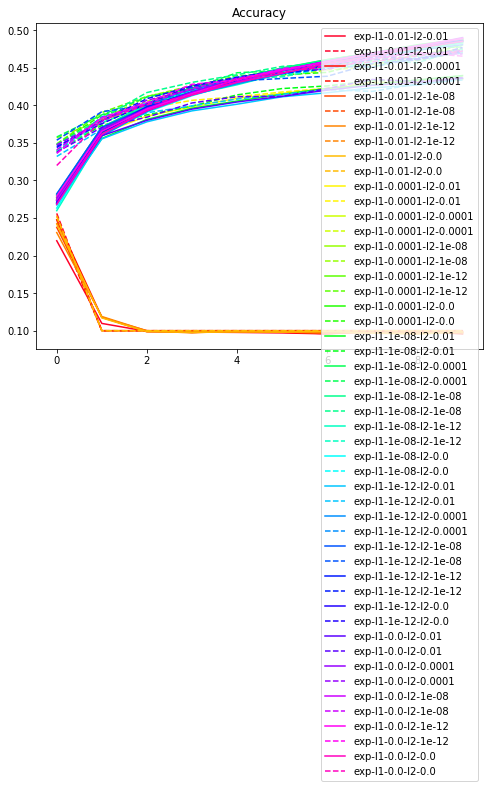

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()